# Excited States via SSVQE

This notebook validates that:
- SSVQE runs for `num_states=k` states
- Works under noise

It prints:
- Lowest $k$ exact eigenvalues of $H$
- SSVQE final energies for states $0, 1, ..., k-1$
- $|ΔE_i|$ versus exact eigenvalue i

In [ ]:
from __future__ import annotations

import numpy as np
import pennylane as qml

from vqe.hamiltonian import build_hamiltonian
from vqe.ssvqe import run_ssvqe
from vqe.visualize import plot_multi_state_convergence


## Configuration

In [ ]:
molecule = "H2"

# k-state target
num_states = 4

# Ansatz/optimizer
ansatz_name = "StronglyEntanglingLayers"
optimizer_name = "Adam"
steps = 250
stepsize = 0.2
seed = 0

# SSVQE weights (None => [1,2,3,...])
weights = None

# Noise knobs (leave at 0 for noiseless section)
depolarizing_prob = 0.00
amplitude_damping_prob = 0.00

## Build Hamiltonian + exact spectrum benchmark

In [3]:
H, n_wires, symbols, coordinates, basis = build_hamiltonian(molecule)
Hmat = np.array(qml.matrix(H), dtype=float)
evals = np.sort(np.linalg.eigvalsh(Hmat))

print(f"Molecule: {molecule}")
print(f"Qubits:   {n_wires}")
print(f"Basis:    {basis}")
print(f"Lowest {max(10, num_states)} exact eigenvalues (Ha):")
for i, e in enumerate(evals[: max(10, num_states)]):
    print(f"#{i:>2}: {float(e): .10f}")

Molecule: H2
Qubits:   4
Basis:    STO-3G
Lowest 10 exact eigenvalues (Ha):
# 0: -1.1372701749
# 1: -0.5387095807
# 2: -0.5387095807
# 3: -0.5324790143
# 4: -0.5324790143
# 5: -0.5324790143
# 6: -0.4469857253
# 7: -0.4469857253
# 8: -0.1699013991
# 9:  0.2378052722


/tmp/ipykernel_101575/1672303132.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  Hmat = np.array(qml.matrix(H), dtype=float)


## Table summary helper

In [4]:
def _summarize_ssvqe(result: dict, exact_evals: np.ndarray, *, label: str) -> None:
    energies = result["energies_per_state"]
    finals = np.array([float(traj[-1]) for traj in energies], dtype=float)

    order = np.argsort(finals)  # canonical: lowest final energy = E0

    print("\n" + "=" * 80)
    print(label)
    print("=" * 80)

    for rank, idx in enumerate(order):
        Ei = float(finals[idx])
        target = float(exact_evals[rank]) if rank < len(exact_evals) else float("nan")
        err = abs(Ei - target) if np.isfinite(target) else float("nan")
        print(
            f"E{rank} (traj={idx}): E_final = {Ei:+.10f} Ha   "
            f"|ΔE| vs exact[{rank}] = {err:.3e} Ha"
        )


## 1) Noiseless k-state SSVQE

In [5]:
noiseless_results = run_ssvqe(
    molecule=molecule,
    num_states=num_states,
    weights=weights,
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    noisy=False,
    depolarizing_prob=0.0,
    amplitude_damping_prob=0.0,
    noise_model=None,
    plot=False,
    force=False,
)

_summarize_ssvqe(noiseless_results, evals, label="Noiseless SSVQE")

💾 Saved SSVQE run to /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__SSVQE(StronglyEntanglingLayers)_4states__Adam__SSVQE__noiseless__s0__39289a6da22b.json

Noiseless SSVQE
E0 (traj=2): E_final = -1.0999922106 Ha   |ΔE| vs exact[0] = 3.728e-02 Ha
E1 (traj=3): E_final = -0.5335373927 Ha   |ΔE| vs exact[1] = 5.172e-03 Ha
E2 (traj=1): E_final = -0.4433766090 Ha   |ΔE| vs exact[2] = 9.533e-02 Ha
E3 (traj=0): E_final = +0.3481392987 Ha   |ΔE| vs exact[3] = 8.806e-01 Ha


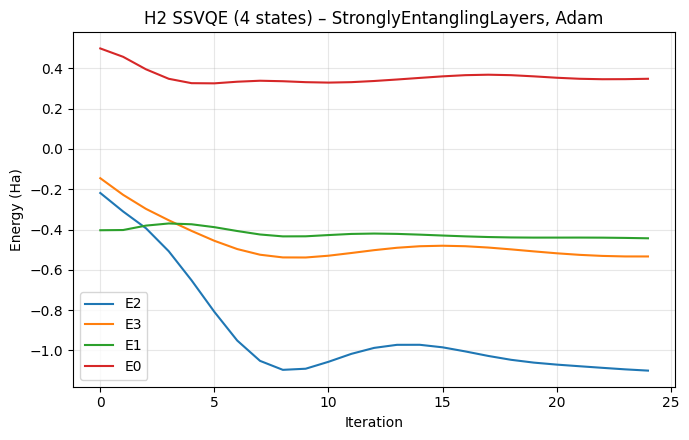

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/ssvqe_conv_StronglyEntanglingLayers_Adam.png


In [ ]:
energies = noiseless_results["energies_per_state"]
finals = np.array([traj[-1] for traj in energies], dtype=float)
order = list(np.argsort(finals))

plot_multi_state_convergence(
    energies_per_state=energies,
    ssvqe_or_vqd="SSVQE",
    molecule=molecule,
    ansatz=ansatz_name,
    optimizer=optimizer_name,
    order=order,
    state_labels=[f"E{i}" for i in range(num_states)],
    show=True,
    save=True,
)


## 2) Noisy SSVQE using built-in depolarizing/amplitude probs

In [7]:
depolarizing_prob = 0.05
amplitude_damping_prob = 0.05

noisy_results = run_ssvqe(
    molecule=molecule,
    num_states=num_states,
    weights=weights,
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    noise_model=None,
    plot=False,
    force=False,
)

_summarize_ssvqe(
    noisy_results,
    evals,
    label=f"Noisy SSVQE: dep={depolarizing_prob}, amp={amplitude_damping_prob}",
)

📂 Using cached SSVQE result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__SSVQE(StronglyEntanglingLayers)_4states__Adam__SSVQE__noisy__s0__6a2a49982eca.json

Noisy SSVQE: dep=0.05, amp=0.05
E0 (traj=2): E_final = -0.9640518964 Ha   |ΔE| vs exact[0] = 1.732e-01 Ha
E1 (traj=1): E_final = -0.4451986936 Ha   |ΔE| vs exact[1] = 9.351e-02 Ha
E2 (traj=3): E_final = -0.4435958639 Ha   |ΔE| vs exact[2] = 9.511e-02 Ha
E3 (traj=0): E_final = +0.2518782232 Ha   |ΔE| vs exact[3] = 7.844e-01 Ha


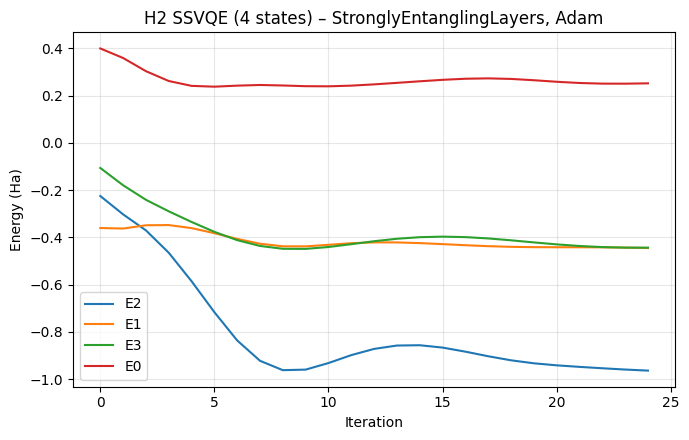

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/ssvqe_conv_StronglyEntanglingLayers_Adam.png


In [8]:
energies = noisy_results["energies_per_state"]
finals = np.array([traj[-1] for traj in energies], dtype=float)
order = list(np.argsort(finals))

plot_multi_state_convergence(
    energies_per_state=energies,
    ssvqe_or_vqd="SSVQE",
    molecule=molecule,
    ansatz=ansatz_name,
    optimizer=optimizer_name,
    order=order,
    state_labels=[f"E{i}" for i in range(num_states)],
    show=True,
    save=True,
)
